## PASO 1: Buscar base de datos para el modelo SIR

Se usará el siguiente data set que muestra los casos de COVID en japón: https://www.kaggle.com/datasets/lisphilar/covid19-dataset-in-japan?resource=download&select=covid_jpn_prefecture.csv

De esta fuente de datos, filtraremos solamente los de la ciudad de tokyo.

NOTA: en el enlace se pueden encontrar 3 csv. Se tomará el de "covid_jpn_prefecture" que contiene los datos que necesitamos

## PASO 2: Estimación de datos (gamma y beta) con el modelo SIR

            Date  Susceptible   Infected  Recovered
12    2020-03-18     13999883       92.0       23.0
59    2020-03-19     13999876       98.0       24.0
106   2020-03-20     13999865      108.0       24.0
153   2020-03-21     13999858      113.0       25.0
200   2020-03-22     13999856      115.0       25.0
...          ...          ...        ...        ...
53592 2023-05-03      9617276  1280630.0  3093983.0
53639 2023-05-04      9616370  1281533.0  3093983.0
53686 2023-05-05      9615308  1282592.0  3093983.0
53733 2023-05-06      9612963  1284934.0  3093983.0
53780 2023-05-07      9611632  1286261.0  3093983.0

[1144 rows x 4 columns]
Estimación de β: 0.08002649265404582
Estimación de γ: 0.06937020412346667


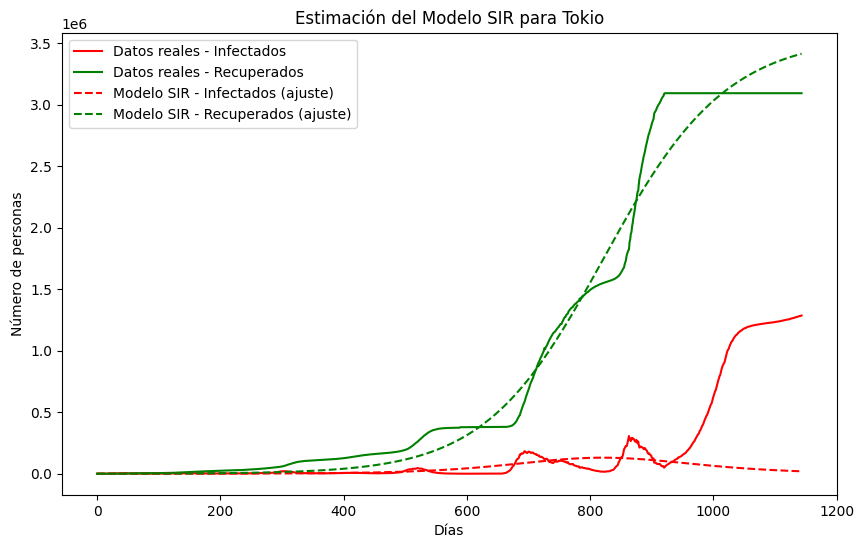

In [5]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Los datos son del año 2020, por lo que tomaremos a la población de Tokio como la de este año

# Cargar la base de datos desde un archivo .csv
url = 'covid_jpn_prefecture.csv'  # Ruta a tu archivo
data = pd.read_csv(url)

# Filtrar los datos solo para Tokio
tokyo_data = data[data['Prefecture'] == 'Tokyo']

# Seleccionar columnas relevantes de Tokio y renombrar para mayor claridad
tokyo_data = tokyo_data[['Date', 'Positive', 'Discharged', 'Fatal']].copy()
tokyo_data['Date'] = pd.to_datetime(tokyo_data['Date'])
tokyo_data = tokyo_data.sort_values('Date')

# Asumimos una población total de Tokio de aproximadamente 14 millones
population_tokyo = 14000000

# Calcular S (Susceptibles), I (Infectados) y R (Recuperados) en cada día
tokyo_data['Infected'] = tokyo_data['Positive'] - tokyo_data['Discharged'] - tokyo_data['Fatal']
tokyo_data['Recovered'] = tokyo_data['Discharged']
tokyo_data['Susceptible'] = population_tokyo - tokyo_data['Positive']

# Eliminar cualquier fila con NaN o inf
tokyo_data = tokyo_data.replace([np.inf, -np.inf], np.nan).dropna()

# Vista preliminar de los datos
print(tokyo_data[['Date', 'Susceptible', 'Infected', 'Recovered']])

# Convertir a arrays para los cálculos
S = tokyo_data['Susceptible'].values
I = tokyo_data['Infected'].values
R = tokyo_data['Recovered'].values
t = np.arange(len(S))  # Tiempo en días

# Funciones diferenciales del modelo SIR
def sir_model(y, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I / population_tokyo
    dI_dt = beta * S * I / population_tokyo - gamma * I
    dR_dt = gamma * I
    return np.array([dS_dt, dI_dt, dR_dt])

# Estimar los valores de beta y gamma usando optimización de mínimos cuadrados
def fit_odeint(t, beta, gamma):
    y = np.array([S[0], I[0], R[0]])  # Condiciones iniciales
    S_pred, I_pred, R_pred = [S[0]], [I[0]], [R[0]]

    # Resolviendo las ecuaciones para cada tiempo t
    for _ in t[1:]:
        y = y + sir_model(y, beta, gamma)
        S_pred.append(y[0])
        I_pred.append(y[1])
        R_pred.append(y[2])

    return np.concatenate([I_pred, R_pred])

# Validación de que no haya NaNs ni infs antes de realizar el ajuste
def validate_data(*arrays):
    for arr in arrays:
        if np.any(np.isnan(arr)) or np.any(np.isinf(arr)):
            raise ValueError("Los datos contienen NaN o infs.")

# Validar los datos antes de ajustar el modelo
validate_data(S, I, R)

# Aplicar curva de ajuste
params, _ = curve_fit(fit_odeint, t, np.concatenate([I, R]), bounds=(0, [1.0, 1.0]))

beta, gamma = params
print(f"Estimación de β: {beta}")
print(f"Estimación de γ: {gamma}")

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(t, I, 'r', label='Datos reales - Infectados')
plt.plot(t, R, 'g', label='Datos reales - Recuperados')
plt.plot(t, fit_odeint(t, beta, gamma)[:len(I)], 'r--', label='Modelo SIR - Infectados (ajuste)')
plt.plot(t, fit_odeint(t, beta, gamma)[len(I):], 'g--', label='Modelo SIR - Recuperados (ajuste)')
plt.xlabel("Días")
plt.ylabel("Número de personas")
plt.legend()
plt.title("Estimación del Modelo SIR para Tokio")
plt.show()


## PASO 2: Modelo SIR

Datos
          Date  Susceptible  Infected  Recovered
12  2020-03-18     13999883      92.0       23.0
59  2020-03-19     13999876      98.0       24.0
106 2020-03-20     13999865     108.0       24.0
153 2020-03-21     13999858     113.0       25.0
200 2020-03-22     13999856     115.0       25.0
------------------------------------------------------------------------------------
Jacobiana en el punto inicial:
[[-1.97142857e-06 -2.99997493e-01  0.00000000e+00]
 [ 1.97142857e-06  1.99997493e-01  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e-01  0.00000000e+00]]
Jacobiana en el punto final:
[[-0.02756274 -0.20596354  0.        ]
 [ 0.02756274  0.10596354  0.        ]
 [ 0.          0.1         0.        ]]
Valores propios de la Jacobiana en el punto inicial:
[0.00000000e+00 1.99994536e-01 9.85741218e-07]
Valores propios de la Jacobiana en el punto final:
[0.       +0.j        0.0392004+0.0349228j 0.0392004-0.0349228j]
El sistema es inestable en el punto inicial.
El sistema es inestabl

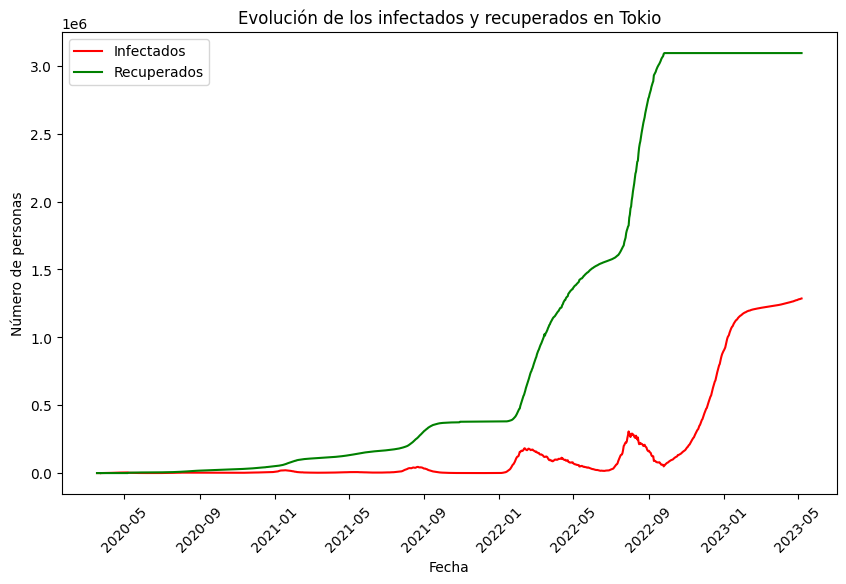

In [13]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Cargar la base de datos desde el archivo CSV
url = 'covid_jpn_prefecture.csv'  # ruta a tu archivo
data = pd.read_csv(url)

# Filtrar los datos solo para Tokio
tokyo_data = data[data['Prefecture'] == 'Tokyo']

# Seleccionar columnas relevantes de Tokio y renombrarlas para mayor claridad
tokyo_data = tokyo_data[['Date', 'Positive', 'Discharged', 'Fatal']].copy()
tokyo_data['Date'] = pd.to_datetime(tokyo_data['Date'])
tokyo_data = tokyo_data.sort_values('Date')

# Asumimos una población total de Tokio de aproximadamente 14 millones
population_tokyo = 14000000

# Calcular S (Susceptibles), I (Infectados) y R (Recuperados) en cada día
tokyo_data['Infected'] = tokyo_data['Positive'] - tokyo_data['Discharged'] - tokyo_data['Fatal']
tokyo_data['Recovered'] = tokyo_data['Discharged']
tokyo_data['Susceptible'] = population_tokyo - tokyo_data['Positive']

# Mostrar los primeros datos para verificar
print("Datos")
print(tokyo_data[['Date', 'Susceptible', 'Infected', 'Recovered']].head())
print("------------------------------------------------------------------------------------")
# --------- Punto 1: Definir el Sistema de Ecuaciones ---------
# Las ecuaciones del modelo SIR se definen aquí.
# La función sir_model calcula las tasas de cambio de S, I y R en función de beta y gamma.

def sir_model(y, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I / population_tokyo
    dI_dt = beta * S * I / population_tokyo - gamma * I
    dR_dt = gamma * I
    print("Punto 1")
    return np.array([dS_dt, dI_dt, dR_dt])
    print("P------------------------------------------------------------------------------------")

# --------- Punto 2: Calcular la Jacobiana ---------
# La Jacobiana del sistema SIR se calcula con la función jacobian.
# Esta matriz contiene las derivadas parciales de las funciones del modelo con respecto a S, I y R.

def jacobian(S, I, R, beta, gamma):
    # Jacobiana del sistema SIR
    J = np.array([[-beta * I / population_tokyo, -beta * S / population_tokyo, 0],
                  [beta * I / population_tokyo, beta * S / population_tokyo - gamma, 0],
                  [0, gamma, 0]])
    return J

# --------- Punto 3: Evaluar la Jacobiana en los Puntos de Equilibrio ---------
# Los valores iniciales y finales dados por el profesor son:

S0 = tokyo_data['Susceptible'].iloc[0]  # Susceptibles iniciales
I0 = tokyo_data['Infected'].iloc[0]  # Infectados iniciales
R0 = tokyo_data['Recovered'].iloc[0]  # Recuperados iniciales

Sf = tokyo_data['Susceptible'].iloc[-1]  # Susceptibles finales
If = tokyo_data['Infected'].iloc[-1]  # Infectados finales
Rf = tokyo_data['Recovered'].iloc[-1]  # Recuperados finales

# Evaluamos la Jacobiana en los puntos de equilibrio: (S0, I0, R0) y (Sf, If, Rf)
def equilibrium_points(S, I, R, beta, gamma):
    # Aquí definimos los puntos de equilibrio en los que el sistema se detendría
    return S, I, R

# Evaluar la Jacobiana en el punto inicial y final
J_eq_initial = jacobian(S0, I0, R0, beta, gamma)
J_eq_final = jacobian(Sf, If, Rf, beta, gamma)

print("Jacobiana en el punto inicial:")
print(J_eq_initial)
print("Jacobiana en el punto final:")
print(J_eq_final)

# --------- Punto 4: Analizar los Valores Propios ---------
# Calculamos los valores propios de la Jacobiana en ambos puntos (inicial y final)

eigenvalues_initial = np.linalg.eigvals(J_eq_initial)
eigenvalues_final = np.linalg.eigvals(J_eq_final)

print("Valores propios de la Jacobiana en el punto inicial:")
print(eigenvalues_initial)

print("Valores propios de la Jacobiana en el punto final:")
print(eigenvalues_final)

# Analizar los valores propios para determinar la estabilidad
if np.any(np.real(eigenvalues_initial) > 0):
    print("El sistema es inestable en el punto inicial.")
else:
    print("El sistema es estable en el punto inicial.")

if np.any(np.real(eigenvalues_final) > 0):
    print("El sistema es inestable en el punto final.")
else:
    print("El sistema es estable en el punto final.")

# --------- Graficar los datos reales ---------
# Finalmente, graficamos los datos de infectados y recuperados a lo largo del tiempo
# para visualizar cómo evolucionaron en Tokio.

plt.figure(figsize=(10, 6))
plt.plot(tokyo_data['Date'], tokyo_data['Infected'], 'r', label='Infectados')
plt.plot(tokyo_data['Date'], tokyo_data['Recovered'], 'g', label='Recuperados')
plt.xlabel("Fecha")
plt.ylabel("Número de personas")
plt.legend()
plt.title("Evolución de los infectados y recuperados en Tokio")
plt.xticks(rotation=45)
plt.show()


## PUNTO 3: Simulación y comparación

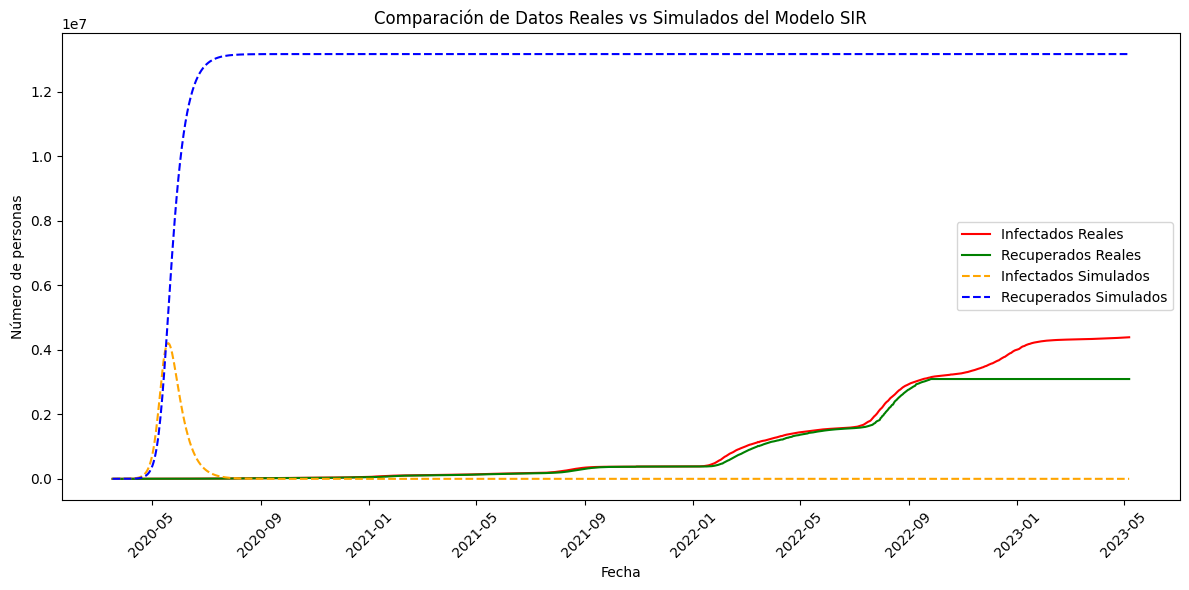

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos de Tokio
url = 'covid_jpn_prefecture.csv'  # ruta a tu archivo
data = pd.read_csv(url)

# Filtrar datos para Tokio
tokyo_data = data[data['Prefecture'] == 'Tokyo']

# Usar .loc para evitar el SettingWithCopyWarning
tokyo_data.loc[:, 'Date'] = pd.to_datetime(tokyo_data['Date'])

# Asegurarnos de que los datos estén ordenados por fecha
tokyo_data = tokyo_data.sort_values('Date')

# Población total de Tokio
population_tokyo = 14000000

# Datos de infectados y recuperados (usando los datos reales)
infectados_real = tokyo_data['Positive']
recuperados_real = tokyo_data['Discharged']

# Definir los parámetros del modelo SIR obtenidos de los datos
beta = 0.3  # Tasa de transmisión, estimación a partir de datos
gamma = 0.1  # Tasa de recuperación, estimación a partir de datos

# Inicializar las condiciones iniciales
I0 = infectados_real.iloc[0]  # Infectados iniciales
R0 = recuperados_real.iloc[0]  # Recuperados iniciales
S0 = population_tokyo - I0 - R0  # Susceptibles iniciales

# Paso 4: Implementar el modelo de Adams-Bashforth para SIR
def adams_bashforth_sir(S0, I0, R0, beta, gamma, h, days):
    # Inicializar las listas para almacenar los resultados
    S = np.zeros(days)
    I = np.zeros(days)
    R = np.zeros(days)
    time = np.arange(days)

    # Condiciones iniciales
    S[0], I[0], R[0] = S0, I0, R0

    # Calcular las primeras 3 iteraciones con el método de Runge-Kutta de 4º orden (RK4)
    for i in range(3):
        # Derivadas (sistema de ecuaciones SIR)
        dS = -beta * S[i] * I[i] / population_tokyo
        dI = beta * S[i] * I[i] / population_tokyo - gamma * I[i]
        dR = gamma * I[i]

        # Paso de Runge-Kutta para obtener los próximos valores
        S[i+1] = S[i] + h * dS
        I[i+1] = I[i] + h * dI
        R[i+1] = R[i] + h * dR

    # Aplicar el método de Adams-Bashforth para el resto de los días
    for n in range(3, days-1):
        # Derivadas en los 4 puntos anteriores
        f0 = -beta * S[n] * I[n] / population_tokyo
        f1 = -beta * S[n-1] * I[n-1] / population_tokyo
        f2 = -beta * S[n-2] * I[n-2] / population_tokyo
        f3 = -beta * S[n-3] * I[n-3] / population_tokyo

        g0 = beta * S[n] * I[n] / population_tokyo - gamma * I[n]
        g1 = beta * S[n-1] * I[n-1] / population_tokyo - gamma * I[n-1]
        g2 = beta * S[n-2] * I[n-2] / population_tokyo - gamma * I[n-2]
        g3 = beta * S[n-3] * I[n-3] / population_tokyo - gamma * I[n-3]

        r0 = gamma * I[n]
        r1 = gamma * I[n-1]
        r2 = gamma * I[n-2]
        r3 = gamma * I[n-3]

        # Método de Adams-Bashforth de 4 pasos
        S[n+1] = S[n] + h/24 * (55*f0 - 59*f1 + 37*f2 - 9*f3)
        I[n+1] = I[n] + h/24 * (55*g0 - 59*g1 + 37*g2 - 9*g3)
        R[n+1] = R[n] + h/24 * (55*r0 - 59*r1 + 37*r2 - 9*r3)

    return time, S, I, R

# Definir el paso temporal (en días) y el número de días a simular
h = 1  # Un día
days = len(tokyo_data)  # Número de días de datos

# Llamar a la función de Adams-Bashforth
time, S_sim, I_sim, R_sim = adams_bashforth_sir(S0, I0, R0, beta, gamma, h, days)

# Paso 5: Comparar los resultados con los datos reales
plt.figure(figsize=(12, 6))

# Graficar los datos reales
plt.plot(tokyo_data['Date'], infectados_real, label='Infectados Reales', color='red')
plt.plot(tokyo_data['Date'], recuperados_real, label='Recuperados Reales', color='green')

# Graficar los resultados simulados
plt.plot(tokyo_data['Date'].iloc[time.astype(int)], I_sim, label='Infectados Simulados', color='orange', linestyle='--')
plt.plot(tokyo_data['Date'].iloc[time.astype(int)], R_sim, label='Recuperados Simulados', color='blue', linestyle='--')

plt.xlabel("Fecha")
plt.ylabel("Número de personas")
plt.title("Comparación de Datos Reales vs Simulados del Modelo SIR")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Datos
          Date  Susceptible  Infected  Recovered
12  2020-03-18     13999883      92.0       23.0
59  2020-03-19     13999876      98.0       24.0
106 2020-03-20     13999865     108.0       24.0
153 2020-03-21     13999858     113.0       25.0
200 2020-03-22     13999856     115.0       25.0
------------------------------------------------------------------------------------
Jacobiana en el punto inicial:
[[-1.97142857e-06 -2.99997493e-01  0.00000000e+00]
 [ 1.97142857e-06  1.99997493e-01  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e-01  0.00000000e+00]]
Jacobiana en el punto final:
[[-0.02756274 -0.20596354  0.        ]
 [ 0.02756274  0.10596354  0.        ]
 [ 0.          0.1         0.        ]]
Valores propios de la Jacobiana en el punto inicial:
[0.00000000e+00 1.99994536e-01 9.85741218e-07]
Valores propios de la Jacobiana en el punto final:
[0.       +0.j        0.0392004+0.0349228j 0.0392004-0.0349228j]
El sistema es inestable en el punto inicial.
El sistema es inestabl

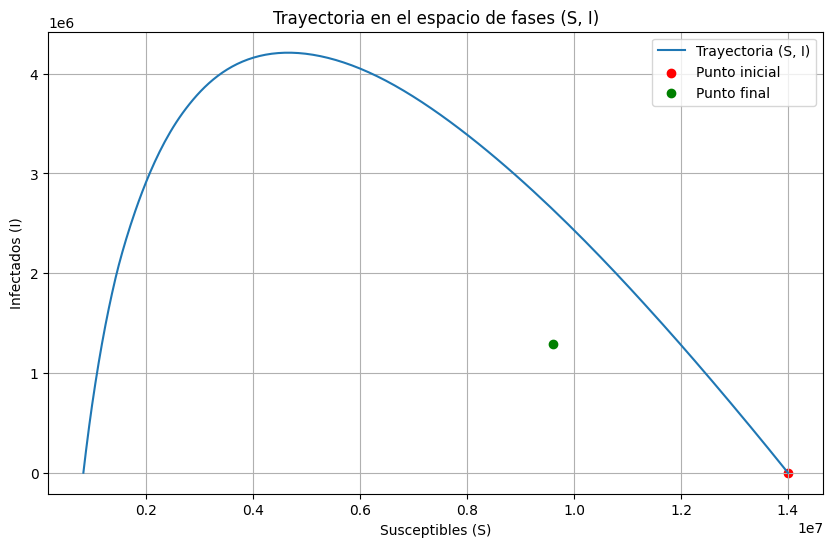

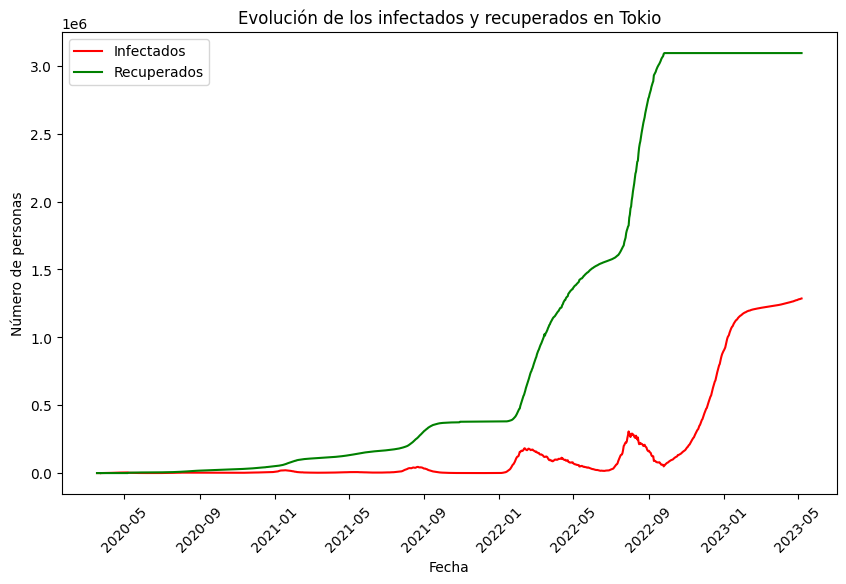

In [14]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Cargar la base de datos desde el archivo CSV
url = 'covid_jpn_prefecture.csv'  # Ruta a tu archivo CSV
data = pd.read_csv(url)

# Filtrar los datos solo para Tokio
tokyo_data = data[data['Prefecture'] == 'Tokyo']

# Seleccionar columnas relevantes de Tokio y renombrarlas para mayor claridad
tokyo_data = tokyo_data[['Date', 'Positive', 'Discharged', 'Fatal']].copy()
tokyo_data['Date'] = pd.to_datetime(tokyo_data['Date'])
tokyo_data = tokyo_data.sort_values('Date')

# Asumimos una población total de Tokio de aproximadamente 14 millones
population_tokyo = 14000000

# Calcular S (Susceptibles), I (Infectados) y R (Recuperados) en cada día
tokyo_data['Infected'] = tokyo_data['Positive'] - tokyo_data['Discharged'] - tokyo_data['Fatal']
tokyo_data['Recovered'] = tokyo_data['Discharged']
tokyo_data['Susceptible'] = population_tokyo - tokyo_data['Positive']

# Mostrar los primeros datos para verificar
print("Datos")
print(tokyo_data[['Date', 'Susceptible', 'Infected', 'Recovered']].head())
print("------------------------------------------------------------------------------------")

# --------- Punto 1: Definir el Sistema de Ecuaciones ---------
# Las ecuaciones del modelo SIR se definen aquí.
def sir_model(y, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I / population_tokyo
    dI_dt = beta * S * I / population_tokyo - gamma * I
    dR_dt = gamma * I
    return np.array([dS_dt, dI_dt, dR_dt])

# --------- Punto 2: Calcular la Jacobiana ---------
def jacobian(S, I, R, beta, gamma):
    # Jacobiana del sistema SIR
    J = np.array([[-beta * I / population_tokyo, -beta * S / population_tokyo, 0],
                  [beta * I / population_tokyo, beta * S / population_tokyo - gamma, 0],
                  [0, gamma, 0]])
    return J

# --------- Punto 3: Evaluar la Jacobiana en los Puntos de Equilibrio ---------
# Los valores iniciales y finales dados por el profesor son:
S0 = tokyo_data['Susceptible'].iloc[0]  # Susceptibles iniciales
I0 = tokyo_data['Infected'].iloc[0]  # Infectados iniciales
R0 = tokyo_data['Recovered'].iloc[0]  # Recuperados iniciales

Sf = tokyo_data['Susceptible'].iloc[-1]  # Susceptibles finales
If = tokyo_data['Infected'].iloc[-1]  # Infectados finales
Rf = tokyo_data['Recovered'].iloc[-1]  # Recuperados finales

# Parámetros del modelo (ejemplo, ajustar según corresponda)
beta = 0.3  # Tasa de transmisión
gamma = 0.1  # Tasa de recuperación

# Evaluar la Jacobiana en el punto inicial y final
J_eq_initial = jacobian(S0, I0, R0, beta, gamma)
J_eq_final = jacobian(Sf, If, Rf, beta, gamma)

print("Jacobiana en el punto inicial:")
print(J_eq_initial)
print("Jacobiana en el punto final:")
print(J_eq_final)

# --------- Punto 4: Analizar los Valores Propios ---------
eigenvalues_initial = np.linalg.eigvals(J_eq_initial)
eigenvalues_final = np.linalg.eigvals(J_eq_final)

print("Valores propios de la Jacobiana en el punto inicial:")
print(eigenvalues_initial)

print("Valores propios de la Jacobiana en el punto final:")
print(eigenvalues_final)

# Analizar los valores propios para determinar la estabilidad
if np.any(np.real(eigenvalues_initial) > 0):
    print("El sistema es inestable en el punto inicial.")
else:
    print("El sistema es estable en el punto inicial.")

if np.any(np.real(eigenvalues_final) > 0):
    print("El sistema es inestable en el punto final.")
else:
    print("El sistema es estable en el punto final.")

# --------- Punto 5: Verificar Órbitas Heteroclínicas ---------
# Simular el modelo SIR y graficar las trayectorias
def sir_equations(t, y, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I / population_tokyo
    dI_dt = beta * S * I / population_tokyo - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

# Condiciones iniciales
y0 = [S0, I0, R0]

# Tiempo de simulación
t_span = [0, 300]  # Simular 300 días
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Puntos de evaluación

# Resolver el sistema de ecuaciones diferenciales
solution = solve_ivp(sir_equations, t_span, y0, args=(beta, gamma), t_eval=t_eval)

# Extraer las trayectorias
S_trajectory, I_trajectory, R_trajectory = solution.y

# Graficar las trayectorias en el espacio de fases
plt.figure(figsize=(10, 6))
plt.plot(S_trajectory, I_trajectory, label="Trayectoria (S, I)")
plt.scatter([S0], [I0], color="red", label="Punto inicial")
plt.scatter([Sf], [If], color="green", label="Punto final")
plt.xlabel("Susceptibles (S)")
plt.ylabel("Infectados (I)")
plt.title("Trayectoria en el espacio de fases (S, I)")
plt.legend()
plt.grid()
plt.show()

# --------- Graficar los datos reales ---------
plt.figure(figsize=(10, 6))
plt.plot(tokyo_data['Date'], tokyo_data['Infected'], 'r', label='Infectados')
plt.plot(tokyo_data['Date'], tokyo_data['Recovered'], 'g', label='Recuperados')
plt.xlabel("Fecha")
plt.ylabel("Número de personas")
plt.legend()
plt.title("Evolución de los infectados y recuperados en Tokio")
plt.xticks(rotation=45)
plt.show()
